*RNN_Model_Years.ipynb* <p style='text-align: right;'> <b> September 20th 2020 </b> </p>
<p style='text-align: right;'> <b> David Diston </b> </p>

# Build an LSTM RNN to Classify the Century when a Piece was Composed

***Once again, trial-and-error tuning was performed when developing this model. The final model iteration is shown here***

The architecture for this model is constructed in the same way as the Composer Classification model, with the exception being the output layer, where now there are 3 output nodes corresponding to the 3 classes (1700, 1800, 1900). The composers in these bins are the 10 composers from the last model. They have been binned based on their birth and death years. Where a composers lifespan crosses a century marker, the century in which he or she lived longest was used for binning (for example: 1892-1950 would be binned as 1900).

As with the data preprocessing notebook, this model notebook follows the same structure as the last model notebook. Therefore, the explainatory commenting will be lower in quantity and focus on differences between these notebooks. If further clarification is required please refer to the `11-RNN_Model_Composers.ipynb` notebook.

In [1]:
import numpy as np
import os
import tensorflow
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# This is the same data import function I have used for the past two models
def training_set(cat, datdir):
    for category in cat:
        path = os.path.join(datdir, category)
        class_num = categories.index(category)
        for array in os.listdir(path):
            try:
                midi_array = np.load(os.path.join(path, array))
                training_data.append([midi_array, class_num])
            except Exception as e:
                pass

In [3]:
# Load Training Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composer_Year/Composer_Year_Data'
categories = ['1700', '1800', '1900']

training_data = []

# Load using above function
training_set(categories, datadirectory)

random.shuffle(training_data)

X = []
y = []

# Append data to the appropriate variable
for features, label in training_data:
    X.append(features)
    y.append(label)

In [4]:
# Load Validation Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composer_Year/Composer_Year_Validation_Set_Data'
categories = ['1700', '1800', '1900']
    
training_data = []
    
training_set(categories, datadirectory)

random.shuffle(training_data)

X_val = []
y_val = []

for features, label in training_data:
    X_val.append(features)
    y_val.append(label)

In [5]:
# Convert to array and transform
X_train = np.array(X).reshape(-1, 100, 88)
y_train = np.array(y)
X_val = np.array(X_val).reshape(-1, 100, 88)
y_val = np.array(y_val)

# Normalize the data
X_train = X_train / 127
X_val = X_val / 127

In [6]:
# Build the model
Century_model = Sequential()

# Again 44 input nodes was found to be most optimal, with 2 hidden layers
Century_model.add(LSTM(44, input_shape = (X_train.shape[1:]), activation = 'relu', return_sequences = True))
Century_model.add(Dropout(0.1))

Century_model.add(LSTM(44, activation='relu'))
Century_model.add(Dropout(0.1))

Century_model.add(Dense(1408, activation='relu'))
Century_model.add(Dropout(0.1))

# The model now has 3 output nodes for the three century classes
Century_model.add(Dense(3, activation='softmax'))

In [7]:
# The same optimizer will be used and will again account for any gradient explosion
opt = Adam(lr = 0.001, decay = 0.00001, clipvalue=0.5)

# Compile the model with the loss, optimizer, and metrics
Century_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = opt,
    metrics=['accuracy'])

# Confirm with a model summary that everything looks correct before training
Century_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 44)           23408     
_________________________________________________________________
dropout (Dropout)            (None, 100, 44)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 44)                15664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44)                0         
_________________________________________________________________
dense (Dense)                (None, 1408)              63360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4

In [8]:
# Create a checkpoint to save the weights from the best performing epoch
checkpoint = ModelCheckpoint('Models/Century_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit  and train the model
# It was found that training beyond 20 epoch did not significantly improve accuracy
Century_model.fit(X_train, y_train,
               batch_size = 50,
               epochs = 20,
               validation_data=(X_val, y_val),
               callbacks=callbacks_list)

Epoch 1/20
299/300 [============================>.] - ETA: 0s - loss: 1.1842 - accuracy: 0.4245
Epoch 00001: val_accuracy improved from -inf to 0.48867, saving model to Models/Century_model.hdf5
300/300 [==============================] - 11s 36ms/step - loss: 1.1834 - accuracy: 0.4250 - val_loss: 1.0051 - val_accuracy: 0.4887
Epoch 2/20
299/300 [============================>.] - ETA: 0s - loss: 1.0208 - accuracy: 0.4720
Epoch 00002: val_accuracy improved from 0.48867 to 0.50267, saving model to Models/Century_model.hdf5
300/300 [==============================] - 11s 35ms/step - loss: 1.0207 - accuracy: 0.4721 - val_loss: 0.9707 - val_accuracy: 0.5027
Epoch 3/20
299/300 [============================>.] - ETA: 0s - loss: 0.9921 - accuracy: 0.5174
Epoch 00003: val_accuracy did not improve from 0.50267
300/300 [==============================] - 11s 35ms/step - loss: 0.9921 - accuracy: 0.5173 - val_loss: 0.9991 - val_accuracy: 0.4887
Epoch 4/20
299/300 [============================>.] - ETA

In [9]:
# Save the complete model
Century_model.save('Models/Century_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/Century_model\assets


#### Model Evaluation

In [10]:
# Import libraries and metrics for model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [11]:
# I will again use my plotting function to plot the confusion matrix from the model predictions
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [12]:
# Load Test Data as I did above for the train and validation data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composer_Year/Composer_Year_Test_Set_Data'
categories = ['1700', '1800', '1900']
    
training_data = []
    
training_set(categories, datadirectory)

# Shuffling is not necessary here, but I do it anyway just for fun!
random.shuffle(training_data)

X_test = []
y_test = []

for features, label in training_data:
    X_test.append(features)
    y_test.append(label)

# Convert to array and reshape
X_test = np.array(X_test).reshape(-1, 100, 88)
y_test = np.array(y_test)

# Normalization
X_test = X_test / 127

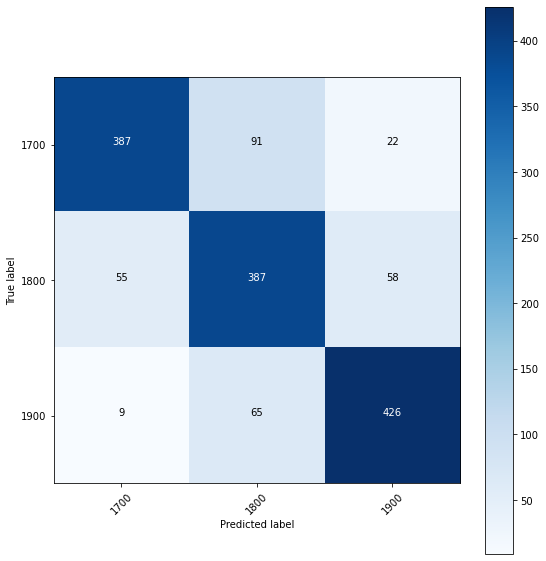

In [13]:
# I get the prediction results from the test set
results = Century_model.predict(X_test, batch_size = 10)

# Concert the class probabilities to class predictions
predicted_classes = np.argmax(results, axis=1)

# Names of predicted classes
class_names = ['1700', '1800', '1900']

# Generate the confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.show()

In [14]:
# Also print out the classification report
CR = classification_report(y_test, predicted_classes)
print(CR)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       500
           1       0.71      0.77      0.74       500
           2       0.84      0.85      0.85       500

    accuracy                           0.80      1500
   macro avg       0.80      0.80      0.80      1500
weighted avg       0.80      0.80      0.80      1500



Based on my musical background, I have to say that the results of this model were expected. The model had the hardest time classifying compositions from the 1800's. Not only was the 1800's a time of great and rapid progress in classical compositional style, leading to a great variety of compositional output, but also the 1800's time period had the greatest variety of unique composers from the original dataset. These factors combined make the 1800's a challenge to classify. That being said the model did a very respectable job classifying between compositions in each of these centuries. From the plotted confusion matrix it does not appear as though there was a particular common mistake that was being made in classification, but rather a general level of inaccuracy throughout the predictions. That being said, errors were more commonly made between adjacent centuries.

For further research it would be intersting to explore a model where compositions are binned based on the compositional epoch in which they were composed. I feel as though, based on these results, such a model would be very successful. Unfortunately based on the composers present in the dataset, it is not possible to separate the data in such a way and ensure proper representation of classical epochs and approximately equal class sizes for such a model. With the inclution of another data source, this may be something I look into in future, and may be a model that makes more sence from a musical perspective.

So far I have had great success with the models I have built. As part of this project I would like to perform one final model investigation, where I compare the classification accuracy of differentiating between two composers at once, and if there is variation in model success based on the composers chosen. To choose composers for this model, I will search for composers with a similar proportion of pieces in the dataset, so as not to have to over or under sample by a significant margin. I would like to present two models: one to classify between composers of different time periods and nationalities, and one to classify between composers of similar time periods and nationalities. Based on these criteria, I have chosen to build a model to classify between Debussy (1800's French) and Mozart (1700's Austrian), and another model to classify between Prokofiev (1900's Russian) and Rachmaninoff (also 1900's Russian).

<p style='text-align: right;'> <b> Next Step: </b> Preprocess data required to build a  Two Composer classification model - <em> Two_Comp_Data_Preparation.ipynb </em> </p>